# Hofbauer Extension

Development code to construct the Hofbauer Extensions for the tent map.

In [1]:
import time
import warnings

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from numpy.linalg import eig
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs

### Defining range functions

In [2]:
def f(a, x):
    """
    Our 'tent map' for the dynamical system.
    a is a parameter that can be adjusted to test for different maps.
    """
    return round(a * np.min([x, 1 - x]), 5)


c_0 = 0.5


def f_L(a, x):
    """
    The left branch of the tent map.
    """
    if x >= 0 and x <= c_0:
        return round(a * x, 8)
    else:
        return [None]


def f_R(a, x):
    """
    The right branch of the tent map.
    """
    if x >= c_0 and x <= 1:
        return round(a * (1 - x), 8)
    else:
        return [None]


def range_f_L(a, interval):
    """
    Finds the range of values produced by the left branch of the tent map on a given interval.
    """
    if interval[0] > c_0:
        return [None]
    if interval[1] > c_0:
        return [f_L(a, interval[0]), f_L(a, c_0)]
    else:
        return [f_L(a, interval[0]), f_L(a, interval[1])]


def range_f_R(a, interval):
    """
    Finds the range of values produced by the right branch of the tent map on a given interval.
    """
    if interval[1] < c_0:
        return [None]
    if interval[0] < c_0:
        return sorted([f_R(a, c_0), f_R(a, interval[1])])
    else:
        return sorted([f_R(a, interval[0]), f_R(a, interval[1])])

### Plotting tent maps

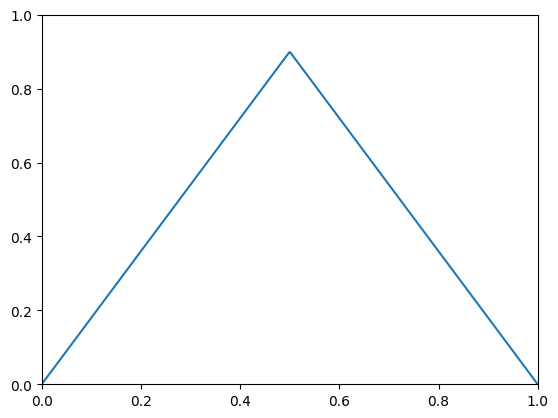

In [3]:
a = 1.8


x = np.linspace(0, 1, 500)

y = []
for i in x:
    y.append(f(a, i))


plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot(x, y)

### Functions for general graphs

In [4]:
def create_digraph(a, limit):
    """
    Creates and stores a directed graph holding information about Hofbauer extension.
    a: float, between 0 and 1 describes the tent map
    lim: int, the limit of the number of iterations
    """
    global G
    G = nx.DiGraph()
    recursive_create_node(G, 0, limit, [0.0, 1.0], a)


def recursive_create_node(G, counter, limit, interval, a):

    if counter >= limit:
        return  # End recursion

    interval_tuple = tuple(interval)

    r_l = range_f_L(a, interval)  # Compute range of left branch on given interval
    r_l_tuple = tuple(r_l)  # Convert list to a tuple for comparison to nodes

    r_r = range_f_R(a, interval)  # Compute range of right branch on given interval
    r_r_tuple = tuple(r_r)  # Convert list to a tuple for comparison to nodes

    if r_l == r_r:  # Branches map to the same range
        if r_l_tuple not in G.nodes:
            G.add_node(r_l_tuple)  # Create node for this range
        if (interval_tuple, r_l_tuple) not in G.edges:
            G.add_edge(
                interval_tuple, r_l_tuple, label="LR"
            )  # Create edge with label indicating both branches map here
        recursive_create_node(
            G, counter + 1, limit, r_l, a
        )  # Recursive call with this range as new interval

    else:
        if r_l != [None]:  # Within domain of left branch
            if r_l_tuple not in G.nodes:
                G.add_node(
                    r_l_tuple
                )  # Create node for the range of left branch for this domain
            if (interval_tuple, r_l_tuple) not in G.edges:
                G.add_edge(
                    interval_tuple, r_l_tuple, label="L"
                )  # Create edge with left label
            recursive_create_node(
                G, counter + 1, limit, r_l, a
            )  # Recursive call with this range as new interval

        if r_r != [None]:  # Within domain of right branch
            if r_r_tuple not in G.nodes:
                G.add_node(
                    r_r_tuple
                )  # Create node for the range of right branch for this domain
            if (interval_tuple, r_r_tuple) not in G.edges:
                G.add_edge(
                    interval_tuple, r_r_tuple, label="R"
                )  # Create edge with right label
            recursive_create_node(
                G, counter + 1, limit, r_r, a
            )  # Recursive call with this range as new interval

### Creating a DiGraph for particular $a$

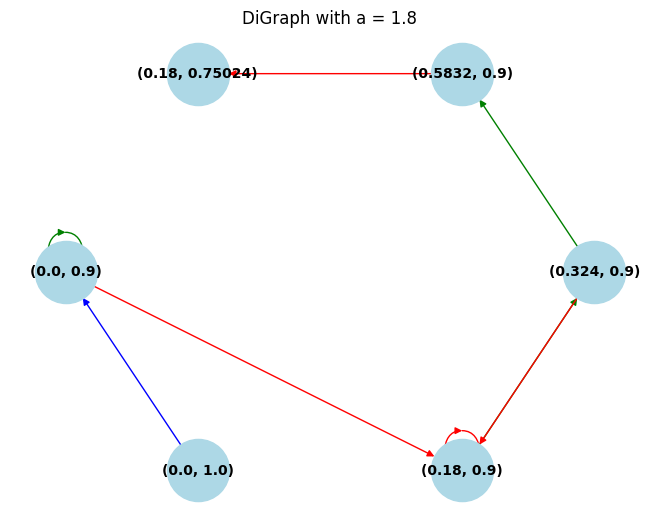

In [5]:
a = 1.8
limit = 5
create_digraph(a, limit)

nodes_list = list(G.nodes)
if len(nodes_list) >= 2:
    nodes_list[0], nodes_list[1] = nodes_list[1], nodes_list[0]

edges_list = []
for u, v, attr in G.edges(data=True):
    edges_list.append([u, v, attr])

# Visualization
edge_colors = [
    (
        "red"
        if attr.get("label") == "R"
        else "green" if attr.get("label") == "L" else "blue"
    )
    for u, v, attr in G.edges(data=True)
]

pos = nx.shell_layout(G)  # Layout for the graph
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color="lightblue",
    edge_color=edge_colors,
    node_size=2000,
    font_size=10,
    font_weight="bold",
)
edge_labels = nx.get_edge_attributes(G, "label")  # Extract edge labels

plt.title(f"DiGraph with a = {a}")
plt.show()

### Adjacency matrix for above DiGraph

In [6]:
df = pd.DataFrame(index=nodes_list, columns=nodes_list)
df.fillna(
    0, inplace=True
)  # Create data frame of all zeroes with dimension equal to number of nodes

for edge in edges_list:
    node1 = edge[0]
    node2 = edge[1]
    label = edge[2]
    if label == {"label": "LR"}:
        df.at[node2, node1] = (
            2  # If both branches map we have 2 edges between these nodes
        )
    else:
        df.at[node2, node1] = (
            1  # Store 1 indicating there is an edge between these nodes
        )

normal_matrix = np.asmatrix(df.values)
w, v = eig(normal_matrix)

C:\Users\dbruw\AppData\Local\Temp\ipykernel_18504\3953759560.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(


### Left and Right Adjacency Matricies for above

In [7]:
df_left = pd.DataFrame(index=nodes_list, columns=nodes_list)
df_right = pd.DataFrame(index=nodes_list, columns=nodes_list)
df_left.fillna(0, inplace=True)
df_right.fillna(0, inplace=True)


for edge in edges_list:
    node1 = edge[0]
    node2 = edge[1]
    label = edge[2]
    if label == {"label": "L"}:
        df_left.at[node2, node1] = 1
    elif label == {"label": "R"}:
        df_right.at[node2, node1] = 1
    else:
        df_left.at[node2, node1] = 1
        df_right.at[node2, node1] = 1

C:\Users\dbruw\AppData\Local\Temp\ipykernel_18504\1038065335.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_left.fillna(0, inplace=True)
C:\Users\dbruw\AppData\Local\Temp\ipykernel_18504\1038065335.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_right.fillna(0, inplace=True)


### Graphing `a` vs largest eigenvalue of adjancency matrix

TIME: 23.80876898765564


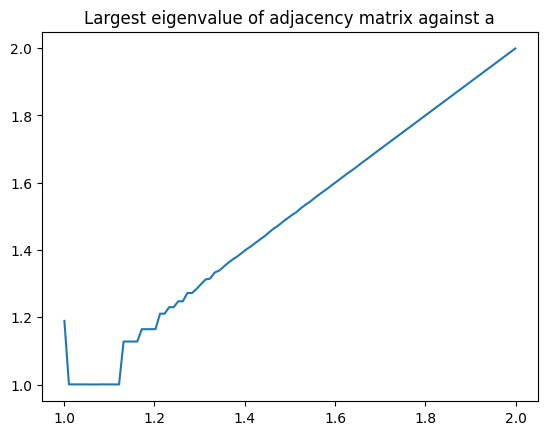

In [8]:
start_time = time.time()  # Start the timer
warnings.filterwarnings("ignore")

x = np.linspace(1.001, 1.999, 100)
y = []

for a in x:
    limit = 17
    G.clear()
    create_digraph(a, limit)

    nodes_list = list(G.nodes)
    nodes_list[0], nodes_list[1] = nodes_list[1], nodes_list[0]

    edges_list = []
    for u, v, attr in G.edges(data=True):
        edges_list.append([u, v, attr])

    df = pd.DataFrame(index=nodes_list, columns=nodes_list)
    df.fillna(0, inplace=True)

    for edge in edges_list:
        node1 = edge[0]
        node2 = edge[1]
        label = edge[2]
        if label == {"label": "LR"}:
            df.at[node2, node1] = 2
        else:
            df.at[node2, node1] = 1

    sparse_matrix = csr_matrix(df.values)
    sparse_matrix = sparse_matrix.asfptype()
    vals, vecs = eigs(sparse_matrix)
    max_eigval = np.max(vals)

    y.append(max_eigval)

plt.title("Largest eigenvalue of adjacency matrix against a")
plt.plot(x, y)

end_time = time.time()  # End the timer
print(f"TIME: {end_time-start_time}")